# RNN - Many-to-one
> In this post, We will briefly cover the many-to-one type, which is one the common types of Recurrent Neural Network and its implementation in tensorflow. 

- toc: true 
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, Deep_Learning, Tensorflow-Keras]
- image: images/many-to-one_detail.png

In [17]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

print('Tensorflow: {}'.format(tf.__version__))

plt.rcParams['figure.figsize'] = (16, 10)
plt.rc('font', size=15)

Tensorflow: 2.3.1


## Various usage of RNN
As we already discussed, RNN is used for sequence data handling. And there are several types of RNN architecture.

![various_rnn](image/various_rnn.png) {% fn 1 %}

In previous [post](https://goodboychan.github.io/chans_jupyter/python/deep_learning/tensorflow-keras/2020/10/26/02-RNN-Basic.html), we take a look **one-to-one** type, which is the basic RNN structure. And next one is **one-to-many** type. For example, if the model gets the fixed format like image as an input, it generates the sequence data. You can see the implementation on image caption application. Another type is **many-to-many** type. It gets sequence data as an inputs, and also generates the sequence data as an output. Common application of many-to-many type is machine translation.

## Many-to-one

**Many-to-one** type, which is our topic in this post, gets an sequence data as an input and generates some informatic data like labels. So we can use it for classification. Suppose that someone defines the sentiment of each sentence, and train the model with many-to-one type. And when the model gets the unseen sentence, then it will predict the intention of sentence, good or bad.

![many-to-one example](image/many-to-one.png)

The detailed explanation is like this.

Suppose we have a sentence, "This movis is good". And we want to classify the sentiment of this sentence. In order to do this, we need to apply tokenization in word level. If this sentensce intends the good sentiment, then word token may contains good words, like "good". So we can classify this sentense to good sentiment.

So if we want to apply it in RNN model, we need to consider the sentence as a word sequence(many), then clssify its label(one). That is process of many-to-one type model.

![many-to-one detail](image/many-to-one_detail.png)

But as you notice, computational model cannot accept the word itself as an input. Instead, it needs to convert with numerical vector. **Embedding** Layer can do this.

So how can we implement this with tensorflow?

## Example - Word sentiment classification

At first, we prepare the dummy data for simple classification. For the simplicity, we defined 1 as a good token, and 0 otherwise.

In [14]:
words = ['good', 'bad', 'worse', 'so good']
y = [1, 0, 0, 1]

Based on this, we can generate the token dictionary, which is the mapping table for each characters. But before we prepare this, we need to consider one exceptional case, the variation of each sentence length. To train the network, the format (or shape) of input data must be fixed. So we need to add the concept of **padding**. Tensorflow has useful API for padding, `pad_sequences`.

In [2]:
char_set = ['<pad>'] + sorted(list(set(''.join(words))))
idx2char = {idx:char for idx, char in enumerate(char_set)}
char2idx = {char:idx for idx, char in enumerate(char_set)}

In [3]:
char_set

['<pad>', ' ', 'a', 'b', 'd', 'e', 'g', 'o', 'r', 's', 'w']

In [4]:
idx2char

{0: '<pad>',
 1: ' ',
 2: 'a',
 3: 'b',
 4: 'd',
 5: 'e',
 6: 'g',
 7: 'o',
 8: 'r',
 9: 's',
 10: 'w'}

In [5]:
char2idx

{'<pad>': 0,
 ' ': 1,
 'a': 2,
 'b': 3,
 'd': 4,
 'e': 5,
 'g': 6,
 'o': 7,
 'r': 8,
 's': 9,
 'w': 10}

So as we mentioned before, we need to vectorize each tokens.

In [6]:
X = list(map(lambda word: [char2idx.get(char) for char in word], words))
X_len = list(map(lambda word: len(word), X))

In [8]:
X

[[6, 7, 7, 4], [3, 2, 4], [10, 7, 8, 9, 5], [9, 7, 1, 6, 7, 7, 4]]

In [9]:
X_len

[4, 3, 5, 7]

In [10]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Padding the sequence of indices
max_sequence=10

X = pad_sequences(X, maxlen=max_sequence, padding='post', truncating='post')

In [11]:
X

array([[ 6,  7,  7,  4,  0,  0,  0,  0,  0,  0],
       [ 3,  2,  4,  0,  0,  0,  0,  0,  0,  0],
       [10,  7,  8,  9,  5,  0,  0,  0,  0,  0],
       [ 9,  7,  1,  6,  7,  7,  4,  0,  0,  0]])

In [15]:
y

[1, 0, 0, 1]

Here, we used `pad_sequences` API with several arguments. First, we defined maximum sequence length to 10. So numerical vector has an maximum length of 10. That is, we just consider 10 characters for sequence. And there are some words that has less than 10 characters. In that case, we filled some 0s for padding. Through argument, we can define the direction of padding, `pre` or `post`.

And of course, it is efficient to use the dataset with generator.

In [20]:
# Generate data pipeline
train_ds = tf.data.Dataset.from_tensor_slices((X, y)).shuffle(buffer_size=4).batch(batch_size=2)
print(train_ds)

<BatchDataset shapes: ((None, 10), (None,)), types: (tf.int32, tf.int32)>


After that, we can build many-to-one model with simpleRNN.

In [18]:
input_dim = len(char2idx)
output_dim = len(char2idx)

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

model = Sequential([
    Embedding(input_dim=input_dim, output_dim=output_dim,
              mask_zero=True, input_length=max_sequence,
              trainable=False, embeddings_initializer=tf.keras.initializers.random_normal()),
    SimpleRNN(units=10),
    Dense(2)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 10, 11)            121       
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 10)                220       
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 22        
Total params: 363
Trainable params: 242
Non-trainable params: 121
_________________________________________________________________


In [30]:
def loss_fn(model, X, y):
    return tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(y_true=y, 
                                                                          y_pred=model(X), 
                                                                          from_logits=True))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [31]:
tr_loss_hist = []

for e in range(30):
    avg_tr_loss = 0
    tr_step = 0
    
    for x_mb, y_mb in train_ds:
        with tf.GradientTape() as tape:
            tr_loss = loss_fn(model, x_mb, y_mb)
            
        grads = tape.gradient(tr_loss, sources=model.variables)
        optimizer.apply_gradients(grads_and_vars=zip(grads, model.variables))
        avg_tr_loss += tr_loss
        tr_step += 1
    
    avg_tr_loss /= tr_step
    tr_loss_hist.append(avg_tr_loss)
    
    if (e + 1) % 5 == 0:
        print('epoch: {:3}, tr_loss: {:3f}'.format(e + 1, avg_tr_loss))

epoch:   5, tr_loss: 0.248861
epoch:  10, tr_loss: 0.018041
epoch:  15, tr_loss: 0.003201
epoch:  20, tr_loss: 0.001664
epoch:  25, tr_loss: 0.001231
epoch:  30, tr_loss: 0.001025


After that, we can check the performance of this simple rnn network

In [32]:
y_pred = model.predict(X)
y_pred = np.argmax(y_pred, axis=-1)

In [33]:
print('acc: {:.2%}'.format(np.mean(y_pred == y)))

acc: 100.00%


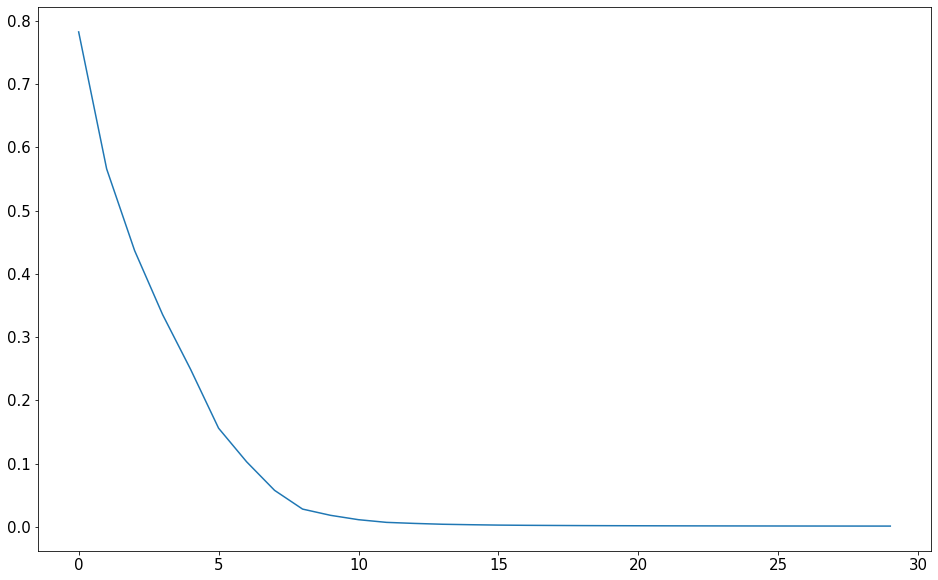

In [34]:
plt.figure()
plt.plot(tr_loss_hist)
plt.show()

As you can see, the performance of this simple network shows almost 100% accuracy.

## Summary

In this post, we just cover the basic concept of **many-to-one** type RNN model for sentiment classification, and implement it with Tensorflow.

{{ 'Reference from stanford CS231n lecture note' | fndetail: 1 }}